# ML for Nuclear Data: A Supervised Learning Starting Point

This notebook trains and evaluates two classical supervised-learning models
-- a Decision Tree and an XGBoost ensemble -- on neutron-induced
cross-section data from the EXFOR database.

### Why nuclear data?

Nuclear cross sections describe the probability of a reaction occurring
when a neutron strikes a target nucleus. They depend on:

- **Energy** -- cross sections vary over many orders of magnitude as
  incident energy changes from thermal (~0.01 eV) to fast (~20 MeV).
- **Isotope** (Z, A) -- each target nucleus has a different cross-section
  curve.
- **Reaction channel** (MT code) -- fission, capture, elastic scattering,
  (n,p), etc. each have distinct energy dependences.

The EXFOR database aggregates experimental measurements from laboratories
worldwide. Individual datasets vary in energy coverage, resolution, and
reported uncertainties, making cross-section prediction a heterogeneous
regression problem.

### Supervised learning setup

| | |
|---|---|
| **Inputs (features)** | Z, A, N, Energy, particle-emission vector, AME2020 nuclear properties |
| **Target** | Cross section $\sigma$ (barns) |
| **Training set** | Full EXFOR database (all isotopes, neutron-induced) |
| **Evaluation isotopes** | U-235 fission (data-rich) and Cl-35 (n,p) (data-sparse) |

### What this notebook covers

- **Data loading** -- EXFOR measurements filtered to neutron-induced
  reactions in the 0.01 eV -- 20 MeV range, with configurable feature tiers.
- **Baseline models** -- Decision Tree and XGBoost, each with randomised
  hyperparameter search so that results reflect tuned performance.
- **Evaluation** -- predictions plotted against EXFOR data and the
  ENDF/B-VIII.0 evaluated library; feature-importance analysis.
- **Interpretation guidance** -- what the metrics and plots show, and what
  to look for when reading the results.


In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from nucml_next.data import NucmlDataset
from nucml_next.baselines import XGBoostEvaluator, DecisionTreeEvaluator

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Verify EXFOR data exists
exfor_path = Path('../data/exfor_processed.parquet')
if not exfor_path.exists():
    raise FileNotFoundError(
        f"EXFOR data not found at {exfor_path}\n"
        "Please run: python scripts/ingest_exfor.py --x4-db data/x4sqlite1.db --output data/exfor_processed.parquet"
    )

print("âœ“ Imports successful")
print("âœ“ EXFOR data found")
print("Welcome to NUCML-Next: Understanding ML Limitations with Real Nuclear Data")

âœ“ Imports successful
âœ“ EXFOR data found
Welcome to NUCML-Next: Understanding ML Limitations with Real Nuclear Data


## Configuration

The cell below sets three groups of options that control the rest of the
notebook:

1. **Feature tiers** -- which AME2020 / NUBASE2020 nuclear-property columns
   to include alongside the core coordinates (Z, A, N, Energy) and
   particle-emission vector.
2. **Transformation pipeline** -- log-scaling for energy and cross section,
   optional feature standardisation.
3. **Uncertainty weighting** -- whether to weight training samples by
   inverse measurement uncertainty, and how to handle missing values.

All settings are defined once here; every subsequent cell reads from these
variables.


In [ ]:
# ============================================================================
# USER CONFIGURATION: Feature Tiers and Transformations
# ============================================================================
# Change these settings in ONE place instead of scattered throughout the notebook

from nucml_next.data.selection import TransformationConfig

# ============================================================================
# FEATURE TIER SELECTION
# ============================================================================
# Choose which AME2020/NUBASE2020 enrichment tiers to include
#
# Tier A (13 features) - ALWAYS INCLUDED:
#   - Z, A, N, Energy (nuclear coordinates)
#   - 9-feature Numerical Particle Vector:
#     out_n, out_p, out_a, out_g, out_f, out_t, out_h, out_d, is_met
#
# Tier B (+2 features) - Geometric:
#   + R_fm (nuclear radius)
#   + kR (dimensionless interaction parameter)
#
# Tier C (+7 features) - Energetics: RECOMMENDED FOR BASELINES
#   + Mass_Excess_MeV (mass excess)
#   + Binding_Energy_MeV (total binding energy)
#   + Binding_Per_Nucleon_MeV (B/A)
#   + S_1n_MeV, S_2n_MeV (neutron separation energies)
#   + S_1p_MeV, S_2p_MeV (proton separation energies)
#
# Tier D (+9 features) - Topological:
#   + Spin, Parity (nuclear structure)
#   + Isomer_Level, Half_Life_log10_s (log10-transformed half-life)
#   + Valence_N, Valence_P (distance to magic numbers)
#   + P_Factor (pairing: even-even/odd-odd)
#   + Shell_Closure_N, Shell_Closure_P
#
# Tier E (+8 features) - Complete Q-values:
#   + Q_alpha_MeV, Q_2beta_minus_MeV, Q_ep_MeV, etc.
#   + All 8 reaction Q-values from AME2020

SELECTED_TIERS = ['A', 'C']  # Change tiers HERE (only place to modify)

print(f"Selected Feature Tiers: {SELECTED_TIERS}")
print(f"   Features: Tier A (core + particle vector) + Tier C (energetics)")
print()

# ============================================================================
# TRANSFORMATION CONFIGURATION
# ============================================================================
# Configure log-scaling and standardization for ML training.
#
# IMPORTANT: For tree-based models (Decision Trees, XGBoost, Random Forest),
# feature scaling is NOT mathematically necessary because trees only care about
# the ordering of values, not their magnitude. Trees find optimal split points
# regardless of scale.
#
# However, log-transforms for Energy and CrossSection ARE important because:
#   - Energy spans ~12 orders of magnitude (1e-5 eV to 1e7 eV)
#   - CrossSection spans ~10 orders of magnitude (microbarns to kilobarns)
#   - Log-transform compresses this range for better numerical stability
#
# For neural networks (future work), scaling IS necessary because gradients
# depend on feature magnitudes. The TransformationPipeline class supports this.

TRANSFORMATION_CONFIG = TransformationConfig(
    # ============================================================================
    # Target (cross-section) transformations
    # ============================================================================
    log_target=True,              # Enable log10 transform for cross-sections
                                  # Stabilizes gradients and handles wide range (ub to kb)
    
    target_epsilon=1e-10,         # Epsilon for log(xs + epsilon) to prevent log(0)
                                  # Increase if you have very small cross-sections
    
    log_base=10,                  # Logarithm base: 10 | 'e' | 2
                                  # Base-10 is standard in nuclear physics
    
    # ============================================================================
    # Energy transformations
    # ============================================================================
    log_energy=True,              # Enable log10 transform for energies
                                  # Handles wide energy range (eV to MeV)
    
    energy_log_base=10,           # Energy log base: 10 | 'e' | 2
    
    # ============================================================================
    # Feature standardization (Z-score, MinMax, etc.)
    # ============================================================================
    # For TREE-BASED models: Set to 'none' (trees are scale-invariant)
    # For NEURAL NETWORKS: Set to 'standard' or 'minmax'
    scaler_type='none',           # Feature scaling method:
                                  # 'none'     = No scaling [DEFAULT for trees]
                                  # 'standard' = Z-score normalization (X-mu)/sigma
                                  # 'minmax'   = Min-max scaling to [0,1]
                                  # 'robust'   = Robust scaling using median and IQR
    
    scale_features=None           # Columns to scale (only used if scaler_type != 'none')
                                  # None = auto-detect numeric columns
                                  # Example: ['Z', 'A', 'N', 'Mass_Excess_MeV']
)

print("Transformation Configuration:")
print(TRANSFORMATION_CONFIG)
print()
print("NOTE: scaler_type='none' because Decision Trees and XGBoost are")
print("      scale-invariant. Log-transforms for Energy/CrossSection are kept.")
print()

# ============================================================================
# UNCERTAINTY WEIGHTING CONFIGURATION
# ============================================================================
# Configure how to use experimental uncertainties during training.
#
# The EXFOR database contains measurement uncertainties for ~66% of cross-section
# values. These uncertainties can be used to weight samples during training,
# giving more influence to precise measurements and less to uncertain ones.
#
# Statistical basis: Inverse-variance weighting (w_i = 1/sigma_i^2) is the
# optimal weighting for least-squares regression when errors are heteroscedastic.

USE_UNCERTAINTY_WEIGHTS = 'xs'    # Uncertainty weighting mode:
                                  # None   = No weighting (equal weight)
                                  # 'xs'   = Weight by cross-section uncertainty (1/sigma_xs^2)
                                  # 'both' = Weight by XS AND energy uncertainty
                                  #          (1/sigma_xs^2 * 1/sigma_E^2)

MISSING_UNCERTAINTY_HANDLING = 'median'
                                  # How to handle samples with missing uncertainties
                                  # (only used when USE_UNCERTAINTY_WEIGHTS is not None):
                                  # 'median'  = Assign median weight from valid samples (default)
                                  # 'equal'   = Assign weight of 1.0
                                  # 'exclude' = Exclude samples without valid uncertainty
                                  #             (equivalent to requiring uncertainty)

print("=" * 80)
print("Uncertainty Weighting Configuration:")
print(f"  USE_UNCERTAINTY_WEIGHTS:       {USE_UNCERTAINTY_WEIGHTS}")
print(f"  MISSING_UNCERTAINTY_HANDLING:  '{MISSING_UNCERTAINTY_HANDLING}'")
if USE_UNCERTAINTY_WEIGHTS:
    print(f"\n  NOTE: Uncertainty weighting enabled (mode='{USE_UNCERTAINTY_WEIGHTS}').")
    print("        Samples with lower uncertainty get higher weight.")
    if MISSING_UNCERTAINTY_HANDLING == 'exclude':
        print("\n  NOTE: MISSING_UNCERTAINTY_HANDLING='exclude' will filter to only")
        print("        samples with valid uncertainty (~66% of data).")
print()
print("To change settings, modify SELECTED_TIERS and TRANSFORMATION_CONFIG above")
print("=" * 80)

## Data: EXFOR-derived processed dataset

The notebook loads a Parquet file produced by the NUCML-Next ingestion
pipeline (`scripts/ingest_exfor.py`). A `DataSelection` object specifies
the selection constraints used here for consistency:

- **Projectile**: neutron only.
- **Energy range**: 1e-5 eV to 2e7 eV (thermal through fast reactor
  energies).
- **Reaction channels**: all physical MT codes, including bookkeeping
  channels (MT 0, 1, >= 9000).
- **Validity filter**: rows with NaN or non-positive cross sections are
  dropped so that log-transforms are well-defined.

The full training set contains all isotopes. Two evaluation isotopes are
loaded separately:

| Isotope | Reaction | Role |
|---------|----------|------|
| U-235 | Fission (MT 18) | Data-rich: thousands of EXFOR points |
| Cl-35 | (n,p) (MT 103) | Data-sparse: tens of EXFOR points |

Comparing a data-rich and a data-sparse case illustrates how model
behaviour changes with measurement density.


In [ ]:
# CRITICAL FIX: Use physics-aware DataSelection for scientifically defensible filtering
# This demonstrates proper ML workflow with predicate pushdown for efficiency

from nucml_next.data import DataSelection

# Strategy: Train on neutron-induced reactions at reactor energies (scientifically defensible default)
# This avoids training on:
# - Non-reactor energies (too high/low for criticality calculations)
# - Non-neutron projectiles (we're focused on reactor physics)
# 
# NOTE: We now INCLUDE all MT codes (including 0, 1, and >=9000) in 'all_physical' mode

print("Creating physics-aware data selection...")
print("=" * 80)

# Training selection: Reactor physics, neutrons, all physical reactions
training_selection = DataSelection(
    # ============================================================================
    # PROJECTILE SELECTION
    # ============================================================================
    projectile='neutron',          # Options: 'neutron' | 'all'
                                   # 'neutron' = Only neutron-induced reactions (reactor physics)
                                   # 'all' = All projectiles (n, p, d, Î±, Î³, etc.)
    
    # ============================================================================
    # ENERGY RANGE (eV)
    # ============================================================================
    energy_min=1e-5,               # Minimum energy in eV (1e-5 = 0.01 eV, thermal neutrons)
    energy_max=2e7,                # Maximum energy in eV (2e7 = 20 MeV, reactor physics upper bound)
                                   # Common ranges:
                                   #   - Thermal: 1e-5 to 1 eV
                                   #   - Resonance: 1 to 1e4 eV
                                   #   - Fast: 1e4 to 2e7 eV (20 MeV)
                                   #   - High energy: up to 1e9 eV (1 GeV)
    
    # ============================================================================
    # REACTION (MT) MODE SELECTION
    # ============================================================================
    mt_mode='all_physical',        # Options:
                                   # 'reactor_core'   â†’ Essential for reactor modeling
                                   #                    (MT 2, 4, 16, 18, 102, 103, 107)
                                   #                    [elastic, inelastic, (n,2n), fission,
                                   #                     capture, (n,p), (n,Î±)]
                                   #
                                   # 'threshold_only' â†’ Reactions with energy thresholds
                                   #                    (MT 16, 17, 103, 104, 105, 106, 107)
                                   #                    [(n,2n), (n,3n), (n,p), (n,d), (n,t),
                                   #                     (n,Â³He), (n,Î±)]
                                   #
                                   # 'fission_details'â†’ Fission breakdown channels
                                   #                    (MT 18, 19, 20, 21, 38)
                                   #                    [total fission, 1st chance, 2nd chance,
                                   #                     3rd chance, 4th chance]
                                   #
                                   # 'all_physical'   â†’ All MT codes including bookkeeping
                                   #                    (MT 0, 1, and >=9000 now INCLUDED)
                                   #
                                   # 'custom'         â†’ Use custom_mt_codes list (see below)
    
    custom_mt_codes=None,          # Used only when mt_mode='custom'
                                   # Example: [2, 18, 102]  # Elastic, fission, capture
                                   # Example: [16, 17, 18]  # (n,2n), (n,3n), fission
                                   # Example: list(range(50, 92))  # MT 50-91 (inelastic levels)
    
    # ============================================================================
    # EXCLUSION RULES
    # ============================================================================
    exclude_bookkeeping=False,     # Set to False to INCLUDE MT 0, 1, and MT >= 9000
                                   # MT 0 = Undefined
                                   # MT 1 = Total cross-section (sum of others)
                                   # MT >= 9000 = Lumped reaction covariances
                                   # Now including these for comprehensive analysis
    
    # ============================================================================
    # DATA VALIDITY
    # ============================================================================
    drop_invalid=True,             # Drop NaN or non-positive cross-sections
                                   # Essential for log-transform: log(Ïƒ) requires Ïƒ > 0
                                   # Prevents training instabilities
    
    # ============================================================================
    # EVALUATION CONTROLS (Holdout for Extrapolation Testing)
    # ============================================================================
    holdout_isotopes=None,         # List of (Z, A) tuples to exclude from training
                                   # None = Use all data (default for training)
                                   # Example: [(92, 235)]           # Hold out U-235 only
                                   # Example: [(92, 235), (17, 35)] # Hold out U-235 and Cl-35
                                   # Example: [(94, 239), (94, 240), (94, 241)]  # Pu isotopes
                                   # Use this to measure TRUE extrapolation capability!
    
    # ============================================================================
    # AME2020/NUBASE2020 ENRICHMENT TIER SELECTION
    # ============================================================================
    tiers=SELECTED_TIERS,          # ðŸŽ¯ Using centralized tier configuration
    transformation_config=TRANSFORMATION_CONFIG  # Using centralized transformation config
)

print("Training Selection:")
print(training_selection)
print()

# Load FULL dataset for training with physics-aware filtering
# CRITICAL: Predicate pushdown filters at PyArrow fragment level (90% I/O reduction!)
print("=" * 80)
print("Loading training dataset with predicate pushdown...")
print("=" * 80)
dataset_full = NucmlDataset(
    data_path='../data/exfor_processed.parquet',
    mode='tabular',
    selection=training_selection  # Physics-aware selection with predicate pushdown
)

# ============================================================================
# Project to tabular format with TIER-BASED features (particle vector)
# ============================================================================
print("\n" + "=" * 80)
print("Projecting to tabular format with particle vector...")
print("=" * 80)

# NOTE: to_tabular() uses particle emission vectors by default (no mode parameter needed)
# This transforms MT codes into physics-aware features (out_n, out_p, out_a, etc.)
# Pass extra_metadata to preserve Energy_Uncertainty when using combined weighting
_extra_meta = ['Energy_Uncertainty'] if USE_UNCERTAINTY_WEIGHTS == 'both' else None
df_tier = dataset_full.to_tabular(extra_metadata=_extra_meta)

print(f"\n[OK] Training dataset: {df_tier.shape}")
print(f"  Energy range: {df_tier['Energy'].min():.2e} to {df_tier['Energy'].max():.2e} eV")

# ============================================================================
# DATA QUALITY: UNCERTAINTY COVERAGE
# ============================================================================
# Display statistics about experimental uncertainty availability.
# This informs users about data quality for uncertainty-weighted training.
#
# From X4Pro C5 format investigation:
# - Total uncertainty (dy â†’ Uncertainty): ~72% coverage in EXFOR
# - Energy uncertainty (dx1 â†’ Energy_Uncertainty): ~55% coverage in EXFOR
#
# These uncertainties are EXCLUDED by default but can be enabled in cell-3.

print("\n" + "=" * 80)
print("DATA QUALITY: UNCERTAINTY COVERAGE")
print("=" * 80)

# Cross-section uncertainty (Uncertainty column)
if 'Uncertainty' in df_tier.columns:
    total_samples = len(df_tier)
    valid_xs_unc = df_tier['Uncertainty'].notna() & (df_tier['Uncertainty'] > 0)
    n_valid_xs_unc = valid_xs_unc.sum()
    pct_xs_unc = 100 * n_valid_xs_unc / total_samples

    print(f"\n  Cross-section uncertainty (Uncertainty column):")
    print(f"    Valid values:    {n_valid_xs_unc:>10,} / {total_samples:,} ({pct_xs_unc:.1f}%)")
    print(f"    Missing/invalid: {total_samples - n_valid_xs_unc:>10,} ({100 - pct_xs_unc:.1f}%)")

    if n_valid_xs_unc > 0:
        valid_unc = df_tier.loc[valid_xs_unc, 'Uncertainty']
        print(f"    Range:           {valid_unc.min():.2e} to {valid_unc.max():.2e} barns")
        print(f"    Median:          {valid_unc.median():.2e} barns")
else:
    print("\n  Cross-section uncertainty: NOT AVAILABLE (Uncertainty column missing)")

# Energy uncertainty (Energy_Uncertainty column) - if present
if 'Energy_Uncertainty' in df_tier.columns:
    valid_e_unc = df_tier['Energy_Uncertainty'].notna() & (df_tier['Energy_Uncertainty'] > 0)
    n_valid_e_unc = valid_e_unc.sum()
    pct_e_unc = 100 * n_valid_e_unc / total_samples

    print(f"\n  Energy uncertainty (Energy_Uncertainty column):")
    print(f"    Valid values:    {n_valid_e_unc:>10,} / {total_samples:,} ({pct_e_unc:.1f}%)")
    print(f"    Missing/invalid: {total_samples - n_valid_e_unc:>10,} ({100 - pct_e_unc:.1f}%)")

    if n_valid_e_unc > 0:
        valid_e_unc_vals = df_tier.loc[valid_e_unc, 'Energy_Uncertainty']
        print(f"    Range:           {valid_e_unc_vals.min():.2e} to {valid_e_unc_vals.max():.2e} eV")
        print(f"    Median:          {valid_e_unc_vals.median():.2e} eV")
else:
    print("\n  Energy uncertainty: NOT AVAILABLE (Energy_Uncertainty column missing)")

# Usage note
print("\n" + "-" * 80)
print("  NOTE: Uncertainties are EXCLUDED from training features by default.")
print("        To enable uncertainty weighting, modify settings in cell-3:")
print("          USE_UNCERTAINTY_WEIGHTS = 'xs'    # Weight by cross-section uncertainty")
print("          USE_UNCERTAINTY_WEIGHTS = 'both'  # Weight by XS AND energy uncertainty")
print("        Set MISSING_UNCERTAINTY_HANDLING = 'exclude' to filter to only")
print("        samples with valid uncertainty. See cell-3 for all options.")
print("        NOTE: Energy_Uncertainty is only included when mode='both'.")
print("=" * 80)

# ============================================================================
# DISPLAY FEATURES BASED ON SELECTED TIERS
# ============================================================================
# Define tier feature mappings for documentation
# NOTE: Half_Life_s is log-transformed to Half_Life_log10_s (spans ~54 orders of magnitude)
TIER_FEATURES = {
    'A': {
        'name': 'Core + Particle Vector',
        'features': ['Z', 'A', 'N', 'Energy', 'out_n', 'out_p', 'out_a', 'out_g', 'out_f', 'out_t', 'out_h', 'out_d', 'is_met'],
        'description': 'Nuclear coordinates (Z, A, N, Energy) + 9-feature particle emission vector'
    },
    'B': {
        'name': 'Geometric',
        'features': ['R_fm', 'kR'],
        'description': 'Nuclear radius and dimensionless interaction parameter'
    },
    'C': {
        'name': 'Energetics',
        'features': ['Mass_Excess_MeV', 'Binding_Energy_MeV', 'Binding_Per_Nucleon_MeV', 'S_1n_MeV', 'S_2n_MeV', 'S_1p_MeV', 'S_2p_MeV'],
        'description': 'Mass excess, binding energies, separation energies (AME2020)'
    },
    'D': {
        'name': 'Topological',
        'features': ['Spin', 'Parity', 'Isomer_Level', 'Half_Life_log10_s', 'Valence_N', 'Valence_P', 'P_Factor', 'Shell_Closure_N', 'Shell_Closure_P'],
        'description': 'Nuclear structure: spin, parity, valence, magic numbers (NUBASE2020). Half-life is log10-transformed.'
    },
    'E': {
        'name': 'Q-values',
        'features': ['Q_alpha', 'Q_2beta_minus', 'Q_ep', 'Q_beta_n', 'Q_4beta_minus', 'Q_d_alpha', 'Q_p_alpha', 'Q_n_alpha'],
        'description': 'Reaction Q-values from AME2020'
    }
}

print(f"\n" + "=" * 60)
print(f"FEATURES AVAILABLE (Based on SELECTED_TIERS = {SELECTED_TIERS})")
print("=" * 60)

total_tier_features = 0
for tier in sorted(SELECTED_TIERS):
    if tier in TIER_FEATURES:
        info = TIER_FEATURES[tier]
        n_features = len(info['features'])
        total_tier_features += n_features
        print(f"\nTier {tier} - {info['name']} ({n_features} features):")
        print(f"  {info['description']}")
        print(f"  Features: {', '.join(info['features'])}")

# Also show metadata columns that are preserved
metadata_cols = ['Entry', 'MT', 'CrossSection', 'Uncertainty']
if USE_UNCERTAINTY_WEIGHTS == 'both':
    metadata_cols.append('Energy_Uncertainty')
print(f"\nMetadata columns (preserved for reference): {', '.join(metadata_cols)}")
print(f"\nTotal: {len(df_tier.columns)} columns in dataframe")
print(f"       ({total_tier_features} tier features + {len(metadata_cols)} metadata)")

print(f"\nAll column names:")
print(df_tier.columns.tolist())

# Show isotope distribution in training data
print("\n[*] Training Data Distribution (Top 10 Isotopes):")
isotope_counts = dataset_full.df.groupby(['Z', 'A']).size().sort_values(ascending=False).head(10)
for (z, a), count in isotope_counts.items():
    # Simple element lookup (extend as needed)
    element_map = {92: 'U', 17: 'Cl', 94: 'Pu', 26: 'Fe', 8: 'O', 1: 'H',
                   82: 'Pb', 6: 'C', 13: 'Al', 7: 'N', 11: 'Na', 79: 'Au'}
    elem = element_map.get(z, f'Z{z}')
    print(f"  {elem}-{a:3d}: {count:>8,} measurements")

print(f"\n[OK] Total isotopes: {dataset_full.df.groupby(['Z', 'A']).ngroups} unique Z/A combinations")
print(f"[OK] Total reaction types: {dataset_full.df['MT'].nunique()} unique MT codes")
print(f"[OK] Total measurements: {len(dataset_full.df):,}")

# Show MT distribution
print("\n[*] Top 10 Reaction Types (MT codes):")
mt_counts = dataset_full.df['MT'].value_counts().head(10)
mt_names = {18: 'Fission', 102: '(n,gamma) Capture', 103: '(n,p)', 2: 'Elastic',
            16: '(n,2n)', 17: '(n,3n)', 4: 'Inelastic', 107: '(n,alpha)',
            0: 'Undefined', 1: 'Total XS'}
for mt, count in mt_counts.items():
    name = mt_names.get(mt, f'MT-{mt}')
    print(f"  MT {mt:3d} {name:15s}: {count:>8,} measurements")

print(f"\n[OK] Training on neutron-induced reactions (reactor energies 0.01 eV - 20 MeV)")
print(f"[OK] Including ALL MT codes (0, 1, and >=9000 now included)")
print(f"[OK] Using Tier A + C features with particle vector transformation")

# Now load evaluation targets (U-235 and Cl-35) using legacy filters for specific selection
print("\n" + "="*70)
print("Loading evaluation targets (U-235 and Cl-35)...")
print(f"NOTE: Using same energy range as training: {training_selection.energy_min:.2e} to {training_selection.energy_max:.2e} eV")
print("="*70)

# Create evaluation selection with same energy limits but specific isotopes
eval_selection = DataSelection(
    projectile='neutron',
    energy_min=training_selection.energy_min,  # SAME as training
    energy_max=training_selection.energy_max,  # SAME as training  
    mt_mode='all_physical',        # Same as training
    exclude_bookkeeping=False,     # Include all MT codes
    drop_invalid=True,
    tiers=SELECTED_TIERS,          # Using centralized tier configuration
)

dataset_eval = NucmlDataset(
    data_path='../data/exfor_processed.parquet',
    mode='tabular',
    selection=eval_selection
)

# Filter to U-235 and Cl-35 only
dataset_eval.df = dataset_eval.df[
    ((dataset_eval.df['Z'] == 92) & (dataset_eval.df['A'] == 235)) |
    ((dataset_eval.df['Z'] == 17) & (dataset_eval.df['A'] == 35))
].copy()

print(f"[OK] Evaluation dataset: {len(dataset_eval.df)} measurements")
print(f"  Energy range: {dataset_eval.df['Energy'].min():.2e} to {dataset_eval.df['Energy'].max():.2e} eV")
print("\n[*] Evaluation Isotopes:")
for (z, a), group in dataset_eval.df.groupby(['Z', 'A']):
    isotope = f"{'U' if z==92 else 'Cl'}-{a}"
    e_min = group['Energy'].min()
    e_max = group['Energy'].max()
    print(f"  {isotope:8s}: {len(group):>6,} measurements (Energy: {e_min:.2e} to {e_max:.2e} eV)")
print("="*70)

# Display sample data transposed for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_tier.sample(5).T.to_string())

### Feature representation

Reaction channels (MT codes) are encoded as a 9-component
**particle-emission vector** (`out_n`, `out_p`, `out_a`, ..., `is_met`)
rather than one-hot indicators. This preserves information about which
particles are emitted in each reaction.

If Tier C is selected, seven AME2020 energetics columns (mass excess,
binding energies, separation energies) are appended. The full set of
available tiers is documented in the configuration cell above.


## Baseline 1 -- Decision Tree

A single Decision Tree is trained on the full EXFOR dataset. To ensure the
results reflect a well-tuned model rather than arbitrary defaults, a
randomised hyperparameter search is run first on a 10 % subsample of the
data, and the best parameters are then used to train on the complete
training set.

A Decision Tree partitions feature space into axis-aligned rectangles,
returning a constant prediction within each rectangle. The resulting
cross-section curve is therefore piecewise constant by construction.


In [ ]:
# ============================================================================
# HYPERPARAMETER OPTIMIZATION FOR DECISION TREE
# ============================================================================
# Use Randomized Search with subsampling to find good hyperparameters efficiently.
# This ensures we're evaluating Decision Trees at their BEST, not strawman configs.
#
# MEMORY OPTIMIZATION: The full dataset (~10M samples) is too large for grid search.
# We use two strategies:
#   1. SUBSAMPLING: Use 10% of data (~1M samples) for hyperparameter search
#   2. RANDOMIZED SEARCH: Sample from parameter space instead of exhaustive grid
#
# The final model is still trained on FULL data with the best found parameters.

# ============================================================================
# USER CONFIGURATION: Hyperparameter Search Space
# ============================================================================

# ----------------------------------------------------------------------------
# max_depth: Maximum tree depth (how many splits from root to leaf)
# ----------------------------------------------------------------------------
# Deeper trees capture more complex patterns but risk overfitting.
# None = unlimited depth (grows until leaves are pure or hit min_samples)
DT_DEPTHS = [40, 60, 80, 100, None]  # Options to sample from

# ----------------------------------------------------------------------------
# min_samples_split: Minimum samples required to split an internal node
# ----------------------------------------------------------------------------
# Higher values = fewer splits = more regularization
DT_MSS_VALUES = [2, 4, 6, 8, 10, 12]  # Options to sample from

# ----------------------------------------------------------------------------
# min_samples_leaf: Minimum samples required in a leaf node
# ----------------------------------------------------------------------------
# Higher values = larger leaves = smoother predictions
DT_MSL_VALUES = [1, 2, 4, 6, 8, 10]  # Options to sample from

# ----------------------------------------------------------------------------
# Subsampling for memory efficiency
# ----------------------------------------------------------------------------
# subsample_fraction: Fraction of data to use for hyperparameter search
#   - 0.1 = 10% of data (~1M samples for 10M dataset)
#   - Reduces memory by ~90%, makes search feasible
#   - Final model trained on FULL data with best params
DT_SUBSAMPLE_FRACTION = 0.1  # 10% of data for search

# subsample_max_samples: Alternative to fraction - absolute maximum
#   - Set to None to use fraction only
#   - Set to e.g., 1_000_000 to cap at 1M samples
DT_SUBSAMPLE_MAX = 1_000_000  # Cap at 1M samples

# ----------------------------------------------------------------------------
# Randomized search settings
# ----------------------------------------------------------------------------
# n_iter: Number of random parameter combinations to try
#   - Higher = more thorough search but slower
#   - 20-50 typically finds good solutions
DT_N_ITER = 20  # Number of random combinations to try

# cv: Number of cross-validation folds
#   - 2-3: Faster, recommended for large datasets
#   - 5: Standard choice if memory allows
DT_CV = 2

# n_jobs: Number of parallel jobs
#   - -1: Use all CPU cores
#   - 1: Sequential (less memory)
DT_N_JOBS = -1

# scoring: Loss function to optimize
DT_SCORING = 'neg_mean_squared_error'

# ============================================================================
# BUILD PARAMETER GRID
# ============================================================================
DT_PARAM_GRID = {
    'max_depth': DT_DEPTHS,
    'min_samples_split': DT_MSS_VALUES,
    'min_samples_leaf': DT_MSL_VALUES,
    'max_features': [None],  # Use all features at each split
}

print("=" * 80)
print("DECISION TREE HYPERPARAMETER OPTIMIZATION (Randomized Search + Subsampling)")
print("=" * 80)
print(f"Parameter search space:")
print(f"  max_depth:         {DT_DEPTHS}")
print(f"  min_samples_split: {DT_MSS_VALUES}")
print(f"  min_samples_leaf:  {DT_MSL_VALUES}")
print(f"\nMemory optimization:")
print(f"  subsample_fraction:    {DT_SUBSAMPLE_FRACTION} ({DT_SUBSAMPLE_FRACTION*100:.0f}% of data)")
print(f"  subsample_max_samples: {DT_SUBSAMPLE_MAX:,}")
print(f"\nOptimization settings:")
print(f"  method: Randomized Search (n_iter={DT_N_ITER})")
print(f"  cv={DT_CV}, n_jobs={DT_N_JOBS}, scoring='{DT_SCORING}'")
print("=" * 80)

# ============================================================================
# RUN RANDOMIZED SEARCH WITH SUBSAMPLING
# ============================================================================
dt_optimizer = DecisionTreeEvaluator()

opt_result_dt = dt_optimizer.optimize_hyperparameters(
    df_tier,
    method='random',  # Randomized search instead of grid
    param_grid=DT_PARAM_GRID,
    n_iter=DT_N_ITER,  # Number of random combinations
    cv_folds=DT_CV,
    scoring=DT_SCORING,
    verbose=True,
    n_jobs=DT_N_JOBS,
    # Memory optimization via subsampling
    subsample_fraction=DT_SUBSAMPLE_FRACTION,
    subsample_max_samples=DT_SUBSAMPLE_MAX,
    # Uncertainty-based sample filtering
    use_uncertainty_weights=USE_UNCERTAINTY_WEIGHTS,
    missing_uncertainty_handling=MISSING_UNCERTAINTY_HANDLING,
)

# ============================================================================
# TRAIN FINAL MODEL WITH OPTIMAL HYPERPARAMETERS ON FULL DATA
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING FINAL MODEL WITH OPTIMAL HYPERPARAMETERS")
print("=" * 80)

# Show uncertainty weighting configuration
print(f"\nUncertainty Weighting:")
print(f"  use_uncertainty_weights:      {USE_UNCERTAINTY_WEIGHTS}")
print(f"  missing_uncertainty_handling: '{MISSING_UNCERTAINTY_HANDLING}'")
print()

dt_model = DecisionTreeEvaluator(**opt_result_dt['best_params'])
dt_metrics = dt_model.train(
    df_tier,
    use_uncertainty_weights=USE_UNCERTAINTY_WEIGHTS,
    missing_uncertainty_handling=MISSING_UNCERTAINTY_HANDLING,
)

print("\n" + "=" * 60)
print("KEY INSIGHT:")
print("=" * 60)
print("This is an OPTIMIZED Decision Tree with hyperparameters found via")
print("Randomized Search on a 10% subsample. The 'staircase effect' you'll")
print("see in the plots is NOT due to poor tuning - it's an inherent")
print("limitation of tree-based models that partition feature space into")
print("axis-aligned rectangles.")
print("=" * 60)

### Decision Tree predictions

The plots below overlay the Decision Tree's predictions on actual EXFOR
data points together with the ENDF/B-VIII.0 evaluated curve.

- **U-235 fission** (data-rich): many training points are available for
  this isotope/reaction.
- **Cl-35 (n,p)** (data-sparse): the model relies on patterns learned from
  other isotopes to fill gaps in energy coverage.

Look at the shape of the predicted curve relative to the ENDF reference
line to see how the model's piecewise-constant structure appears in
practice.


In [ ]:
# ============================================================================
# VISUALIZATION: U-235 (data-rich) vs Cl-35 (data-sparse) with CrossSectionFigure
# ============================================================================
# Using the modular visualization framework for publication-quality plots.
# CrossSectionFigure provides:
#   - Automatic ENDF-B overlay for comparison with evaluated data
#   - EXFOR experimental data display
#   - ML model predictions
#   - Method chaining API for clean, readable code

from nucml_next.visualization import CrossSectionFigure

# ============================================================================
# FIXED ENERGY RANGE FOR PLOTS
# ============================================================================
E_MIN_PLOT = 1e-4   # 10^-4 eV
E_MAX_PLOT = 1e7    # 10^7 eV

# ============================================================================
# HELPER: Clip predictions to positive values for log scale
# ============================================================================
def _clip_positive(arr, floor=1e-30):
    """Clip array values to minimum positive floor for log scale."""
    arr = np.asarray(arr)
    return np.clip(arr, floor, None)

# ============================================================================
# LEFT PANEL: U-235 Fission (Data-Rich)
# ============================================================================

Z_u, A_u, mt_u = 92, 235, 18  # U-235 Fission

# Extract U-235 fission data from training set for prediction
mask_u_train = (df_tier['Z'] == Z_u) & (df_tier['A'] == A_u)
df_u_train = df_tier[mask_u_train].copy()
df_u_train = df_u_train[(df_u_train['Energy'] >= E_MIN_PLOT) & (df_u_train['Energy'] <= E_MAX_PLOT)]
df_u_train = df_u_train.sort_values('Energy').reset_index(drop=True)

# Get Decision Tree predictions on actual data points
predictions_dt_u = dt_model.predict(df_u_train)
predictions_dt_u = _clip_positive(predictions_dt_u)
energies_dt_u = df_u_train['Energy'].values

# Extract U-235 fission EXFOR ground truth for plotting
mask_u_eval = (dataset_eval.df['Z'] == Z_u) & (dataset_eval.df['A'] == A_u) & (dataset_eval.df['MT'] == mt_u)
df_u = dataset_eval.df[mask_u_eval].copy()
df_u = df_u[(df_u['Energy'] > 0) & (df_u['CrossSection'] > 0)]
df_u = df_u[(df_u['Energy'] >= E_MIN_PLOT) & (df_u['Energy'] <= E_MAX_PLOT)]

# Create U-235 figure using CrossSectionFigure
fig_u235 = (
    CrossSectionFigure(
        isotope='U-235',
        mt=18,
        title='U-235 Fission (DATA-RICH): Staircase Effect vs ENDF-B',
        figsize=(14, 7),
        endf_dir='../data/ENDF-B/neutrons',
    )
    .add_exfor(
        df_u,
        label=f'EXFOR ({len(df_u)} pts)',
        color='tab:blue',
        s=30,
        alpha=0.5,
        zorder=1,
    )
    .add_endf_auto(
        color='black',
        linewidth=1.5,
        linestyle='-',
        alpha=0.8,
        label='ENDF/B-VIII.0 (Evaluated)',
        zorder=2,
    )
    .add_model(
        energies_dt_u,
        predictions_dt_u,
        label='Decision Tree (Staircase)',
        color='tab:red',
        linewidth=2.5,
        linestyle='-',
        alpha=0.9,
        zorder=3,
    )
    .set_energy_range(E_MIN_PLOT, E_MAX_PLOT)
    .add_legend(loc='best', fontsize=11)
)

# Add annotation for staircase effect
if len(predictions_dt_u) > 250:
    mid_idx = len(predictions_dt_u) // 2
    sort_idx = np.argsort(energies_dt_u)
    fig_u235.add_annotation(
        'Unphysical steps!\n(ENDF curve is smooth)',
        xy=(energies_dt_u[sort_idx][mid_idx], predictions_dt_u[sort_idx][mid_idx]),
        xytext=(energies_dt_u[sort_idx][mid_idx] * 2, predictions_dt_u[sort_idx][mid_idx] * 3),
        arrowprops={'arrowstyle': '->', 'color': 'tab:red', 'lw': 2},
        color='tab:red',
        bbox={'boxstyle': 'round', 'facecolor': 'yellow', 'alpha': 0.7},
    )

fig_u235.show()

# ============================================================================
# RIGHT PANEL: Cl-35 (n,p) (Data-Sparse)
# ============================================================================

Z_cl, A_cl, mt_cl = 17, 35, 103  # Cl-35 (n,p)

# Extract Cl-35 data from training set for prediction
mask_cl_train = (df_tier['Z'] == Z_cl) & (df_tier['A'] == A_cl)
df_cl_train = df_tier[mask_cl_train].copy()
df_cl_train = df_cl_train[(df_cl_train['Energy'] >= E_MIN_PLOT) & (df_cl_train['Energy'] <= E_MAX_PLOT)]
df_cl_train = df_cl_train.sort_values('Energy').reset_index(drop=True)

# Get Decision Tree predictions on actual data points
predictions_dt_cl = dt_model.predict(df_cl_train)
predictions_dt_cl = _clip_positive(predictions_dt_cl)
energies_dt_cl = df_cl_train['Energy'].values

# Extract Cl-35 (n,p) EXFOR ground truth for plotting
mask_cl_eval = (dataset_eval.df['Z'] == Z_cl) & (dataset_eval.df['A'] == A_cl) & (dataset_eval.df['MT'] == mt_cl)
df_cl = dataset_eval.df[mask_cl_eval].copy()
df_cl = df_cl[(df_cl['Energy'] > 0) & (df_cl['CrossSection'] > 0)]
df_cl = df_cl[(df_cl['Energy'] >= E_MIN_PLOT) & (df_cl['Energy'] <= E_MAX_PLOT)]

# Create Cl-35 figure using CrossSectionFigure
fig_cl35 = (
    CrossSectionFigure(
        isotope='Cl-35',
        mt=103,
        title='Cl-35 (n,p) (DATA-SPARSE): Transfer Learning Test vs ENDF-B',
        figsize=(14, 7),
        endf_dir='../data/ENDF-B/neutrons',
    )
    .add_exfor(
        df_cl,
        label=f'EXFOR ({len(df_cl)} pts)',
        color='tab:blue',
        s=80,
        alpha=0.6,
        edgecolors='black',
        zorder=1,
    )
    .add_endf_auto(
        color='black',
        linewidth=1.5,
        linestyle='-',
        alpha=0.8,
        label='ENDF/B-VIII.0 (Evaluated)',
        zorder=2,
    )
    .add_model(
        energies_dt_cl,
        predictions_dt_cl,
        label='Decision Tree (Extrapolation)',
        color='tab:red',
        linewidth=2.5,
        linestyle='-',
        alpha=0.9,
        zorder=3,
    )
    .set_energy_range(E_MIN_PLOT, E_MAX_PLOT)
    .add_legend(loc='best', fontsize=11)
)

# Add annotation
if len(predictions_dt_cl) > 10:
    mid_idx = len(predictions_dt_cl) // 2
    sort_idx_cl = np.argsort(energies_dt_cl)
    fig_cl35.add_annotation(
        'Can the model\ntransfer knowledge?',
        xy=(energies_dt_cl[sort_idx_cl][mid_idx], predictions_dt_cl[sort_idx_cl][mid_idx]),
        xytext=(energies_dt_cl[sort_idx_cl][mid_idx] * 1.5, predictions_dt_cl[sort_idx_cl][mid_idx] * 0.5),
        arrowprops={'arrowstyle': '->', 'color': 'tab:red', 'lw': 2},
        color='tab:red',
        bbox={'boxstyle': 'round', 'facecolor': 'yellow', 'alpha': 0.7},
    )

fig_cl35.show()

# ============================================================================
# OBSERVATIONS
# ============================================================================

print("\n" + "=" * 80)
print("OBSERVATIONS: Decision Tree vs ENDF-B Evaluated Data")
print("=" * 80)
print(f"Fixed Plot Range: {E_MIN_PLOT:.2e} to {E_MAX_PLOT:.2e} eV")
print()
print("NEW: ENDF/B-VIII.0 evaluated data overlay (black line) shows the 'ground truth'")
print("     that reactor physicists trust. Compare ML predictions against this!")
print()
print("U-235 Fission (Data-Rich):")
print("  â€¢ ENDF-B curve is SMOOTH (physics-based evaluation)")
print("  â€¢ Decision Tree creates JAGGED predictions (staircase effect)")
print("  â€¢ Blue scatter: EXFOR experimental measurements")
print("  â€¢ Red line: Decision Tree - discontinuous, unphysical")
print()
print("Cl-35 (n,p) (Data-Sparse):")
print("  â€¢ ENDF-B provides smooth reference even where EXFOR is sparse")
print("  â€¢ Decision Tree must transfer knowledge from other isotopes")
print("  â€¢ Large gaps between measurements test generalization")
print("  â€¢ This is where physics-informed models REALLY shine!")
print("=" * 80)

### How Decision Trees produce predictions

A Decision Tree recursively splits on feature thresholds:

```
if Energy < 10.5:
    if Energy < 5.2:
        return 150.0   # constant within this leaf
    else:
        return 89.0    # discontinuous jump at boundary
else:
    return 45.0
```

Each leaf returns a single value, so the predicted cross-section curve is a
step function regardless of how the tree is tuned. Compare this with the
smooth Breit-Wigner form that describes resonance peaks in nuclear
cross sections:

$$\sigma(E) = \sigma_0 \frac{\Gamma}{(E - E_r)^2 + \Gamma^2/4}$$

---

## Baseline 2 -- XGBoost

XGBoost builds an ensemble of shallow decision trees via gradient boosting.
Because many trees contribute to each prediction, the resulting curve is
a sum of many step functions -- still piecewise constant, but with finer
steps.

The same randomised hyperparameter search and subsampling strategy are
applied here.


In [ ]:
# ============================================================================
# HYPERPARAMETER OPTIMIZATION FOR XGBOOST
# ============================================================================
# Use Randomized Search with subsampling to find good hyperparameters efficiently.
# XGBoost is an ensemble of decision trees trained via gradient boosting.
#
# MEMORY OPTIMIZATION: The full dataset (~10M samples) is too large for grid search.
# We use two strategies:
#   1. SUBSAMPLING: Use 10% of data (~1M samples) for hyperparameter search
#   2. RANDOMIZED SEARCH: Sample from parameter space instead of exhaustive grid
#
# The final model is still trained on FULL data with the best found parameters.

# ============================================================================
# USER CONFIGURATION: Hyperparameter Search Space
# ============================================================================

# ----------------------------------------------------------------------------
# n_estimators: Number of boosting rounds (trees in the ensemble)
# ----------------------------------------------------------------------------
# More trees = more capacity, but diminishing returns after ~200-500
XGB_ESTIMATORS = [100, 150, 200, 250, 300]  # Options to sample from

# ----------------------------------------------------------------------------
# max_depth: Maximum depth of each tree in the ensemble
# ----------------------------------------------------------------------------
# XGBoost trees are typically SHALLOWER than single Decision Trees
# because the ensemble combines many weak learners.
XGB_DEPTHS = [4, 5, 6, 7, 8, 10]  # Options to sample from

# ----------------------------------------------------------------------------
# learning_rate (eta): Step size shrinkage to prevent overfitting
# ----------------------------------------------------------------------------
# Lower = more conservative, needs more trees
# Higher = faster learning, risk of overfitting
XGB_LEARNING_RATES = [0.01, 0.05, 0.1, 0.15, 0.2]  # Options to sample from

# ----------------------------------------------------------------------------
# subsample: Fraction of training samples used per tree
# ----------------------------------------------------------------------------
# Lower values add randomness, reducing overfitting
XGB_SUBSAMPLES = [0.7, 0.8, 0.9, 1.0]  # Options to sample from

# ----------------------------------------------------------------------------
# colsample_bytree: Fraction of features used per tree
# ----------------------------------------------------------------------------
XGB_COLSAMPLE = [0.7, 0.8, 0.9, 1.0]  # Options to sample from

# ----------------------------------------------------------------------------
# Subsampling for memory efficiency (data subsampling, not XGBoost subsample)
# ----------------------------------------------------------------------------
XGB_DATA_SUBSAMPLE_FRACTION = 0.1  # 10% of data for search
XGB_DATA_SUBSAMPLE_MAX = 1_000_000  # Cap at 1M samples

# ----------------------------------------------------------------------------
# Randomized search settings
# ----------------------------------------------------------------------------
XGB_N_ITER = 20  # Number of random combinations to try
XGB_CV = 2  # Cross-validation folds
XGB_N_JOBS = -1  # Use all CPU cores
XGB_SCORING = 'neg_mean_squared_error'

# ============================================================================
# BUILD PARAMETER GRID
# ============================================================================
XGB_PARAM_GRID = {
    'n_estimators': XGB_ESTIMATORS,
    'max_depth': XGB_DEPTHS,
    'learning_rate': XGB_LEARNING_RATES,
    'subsample': XGB_SUBSAMPLES,
    'colsample_bytree': XGB_COLSAMPLE,
}

print("=" * 80)
print("XGBOOST HYPERPARAMETER OPTIMIZATION (Randomized Search + Subsampling)")
print("=" * 80)
print(f"Parameter search space:")
print(f"  n_estimators:     {XGB_ESTIMATORS}")
print(f"  max_depth:        {XGB_DEPTHS}")
print(f"  learning_rate:    {XGB_LEARNING_RATES}")
print(f"  subsample:        {XGB_SUBSAMPLES}")
print(f"  colsample_bytree: {XGB_COLSAMPLE}")
print(f"\nMemory optimization:")
print(f"  data_subsample_fraction: {XGB_DATA_SUBSAMPLE_FRACTION} ({XGB_DATA_SUBSAMPLE_FRACTION*100:.0f}% of data)")
print(f"  data_subsample_max:      {XGB_DATA_SUBSAMPLE_MAX:,}")
print(f"\nOptimization settings:")
print(f"  method: Randomized Search (n_iter={XGB_N_ITER})")
print(f"  cv={XGB_CV}, n_jobs={XGB_N_JOBS}, scoring='{XGB_SCORING}'")
print("=" * 80)

# ============================================================================
# PREPARE DATA FOR RANDOMIZED SEARCH
# ============================================================================
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from nucml_next.data.transformations import TransformationPipeline
from nucml_next.data.selection import TransformationConfig
from sklearn.model_selection import train_test_split
import numpy as np

# Create transformation pipeline
xgb_transform_config = TransformationConfig(
    log_target=True,
    target_epsilon=1e-10,
    log_base=10,
    log_energy=True,
    energy_log_base=10,
    scaler_type='standard',
)

# Get feature columns (same logic as evaluators)
exclude_columns = ['CrossSection', 'Uncertainty', 'Energy_Uncertainty', 'Entry', 'MT']
numeric_cols = df_tier.select_dtypes(include=[np.number]).columns.tolist()
feature_columns = [col for col in numeric_cols if col not in exclude_columns]

X_features = df_tier[feature_columns]
y = df_tier['CrossSection']
energy = df_tier['Energy']

# Fit and transform
xgb_pipeline = TransformationPipeline(config=xgb_transform_config)
xgb_pipeline.fit(X_features, y, energy, feature_columns=feature_columns)

X_transformed = xgb_pipeline.transform(X_features, energy)
y_transformed = xgb_pipeline.transform_target(y)

X_arr = X_transformed[feature_columns].values
y_arr = y_transformed.values

# Handle NaN/inf
valid_target = np.isfinite(y_arr)
if not valid_target.all():
    print(f"  Removing {(~valid_target).sum():,} rows with invalid target")
    X_arr = X_arr[valid_target]
    y_arr = y_arr[valid_target]

if MISSING_UNCERTAINTY_HANDLING == 'exclude':
    # Drop rows with any NaN/inf in features (no imputation)
    nan_rows = np.isnan(X_arr).any(axis=1) | np.isinf(X_arr).any(axis=1)
    if nan_rows.any():
        n_before = len(X_arr)
        X_arr = X_arr[~nan_rows]
        y_arr = y_arr[~nan_rows]
        print(f"  Dropping {n_before - len(X_arr):,} rows with NaN/inf features (exclude mode)")
else:
    X_arr = np.nan_to_num(X_arr, nan=0.0, posinf=1e10, neginf=-1e10)

print(f"\nFull dataset: {X_arr.shape[0]:,} samples x {X_arr.shape[1]} features")

# ============================================================================
# APPLY SUBSAMPLING FOR HYPERPARAMETER SEARCH
# ============================================================================
n_samples = len(X_arr)
target_size = min(
    int(n_samples * XGB_DATA_SUBSAMPLE_FRACTION),
    XGB_DATA_SUBSAMPLE_MAX
)

if target_size < n_samples:
    rng = np.random.default_rng(42)
    subsample_idx = rng.choice(n_samples, size=target_size, replace=False)
    X_arr_search = X_arr[subsample_idx]
    y_arr_search = y_arr[subsample_idx]
    print(f"Subsampled for search: {n_samples:,} â†’ {target_size:,} samples ({100*target_size/n_samples:.1f}%)")
else:
    X_arr_search = X_arr
    y_arr_search = y_arr

# Split subsampled data for search
X_train_search, X_test_search, y_train_search, y_test_search = train_test_split(
    X_arr_search, y_arr_search, test_size=0.2, random_state=42
)

# Also split full data for final evaluation
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_arr, y_arr, test_size=0.2, random_state=42
)

print(f"Search train set: {len(X_train_search):,} samples")
print(f"Full train set:   {len(X_train_full):,} samples")

# ============================================================================
# RUN RANDOMIZED SEARCH
# ============================================================================
print("\nStarting Randomized Search...")
print("-" * 80)

base_xgb = xgb.XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    verbosity=0,
)

random_search = RandomizedSearchCV(
    base_xgb,
    XGB_PARAM_GRID,
    n_iter=XGB_N_ITER,
    cv=XGB_CV,
    scoring=XGB_SCORING,
    n_jobs=XGB_N_JOBS,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

random_search.fit(X_train_search, y_train_search)

print("-" * 80)

# Get best params
best_params_xgb = random_search.best_params_.copy()
best_params_xgb['random_state'] = 42

print("\n" + "=" * 80)
print("SEARCH COMPLETE")
print("=" * 80)
print(f"Best CV Score ({XGB_SCORING}): {random_search.best_score_:.6f}")
print()
print("Optimal Hyperparameters (found on subsampled data):")
for key, value in best_params_xgb.items():
    if key != 'random_state':
        print(f"  {key:20s}: {value}")

# ============================================================================
# RETRAIN ON FULL DATA WITH BEST PARAMETERS
# ============================================================================
print("\n" + "=" * 80)
print("RETRAINING ON FULL DATA WITH OPTIMAL HYPERPARAMETERS")
print(f"Training set: {len(X_train_full):,} samples")
print("=" * 80)

final_xgb = xgb.XGBRegressor(
    **best_params_xgb,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    verbosity=0,
)
final_xgb.fit(X_train_full, y_train_full)

# Evaluate on full test set
y_test_pred = final_xgb.predict(X_test_full)

# Inverse transform
import pandas as pd
y_test_pred_orig = xgb_pipeline.inverse_transform_target(pd.Series(y_test_pred)).values
y_test_orig = xgb_pipeline.inverse_transform_target(pd.Series(y_test_full)).values

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
test_mse = mean_squared_error(y_test_orig, y_test_pred_orig)
test_mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
test_r2 = r2_score(y_test_orig, y_test_pred_orig)

print(f"\nFinal Model Performance (on full test set):")
print(f"  Test MSE: {test_mse:.4e}")
print(f"  Test MAE: {test_mae:.4e}")
print(f"  Test RÂ²:  {test_r2:.4f}")

# ============================================================================
# TRAIN FINAL MODEL VIA EVALUATOR FOR CONSISTENT API
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING FINAL MODEL WITH EVALUATOR API")
print("=" * 80)

# Show uncertainty weighting configuration
print(f"\nUncertainty Weighting:")
print(f"  use_uncertainty_weights:      {USE_UNCERTAINTY_WEIGHTS}")
print(f"  missing_uncertainty_handling: '{MISSING_UNCERTAINTY_HANDLING}'")
print()

xgb_model = XGBoostEvaluator(**best_params_xgb)
xgb_metrics = xgb_model.train(
    df_tier,
    use_uncertainty_weights=USE_UNCERTAINTY_WEIGHTS,
    missing_uncertainty_handling=MISSING_UNCERTAINTY_HANDLING,
)

# Store pipeline for predictions
xgb_model.pipeline = xgb_pipeline
xgb_model.feature_columns = feature_columns

print("\n" + "=" * 60)
print("KEY INSIGHT:")
print("=" * 60)
print("XGBoost produces SMOOTHER predictions than a single Decision Tree")
print("because it averages many shallow trees. However, it's still")
print("fundamentally piecewise constant - just with more (smaller) steps.")
print("=" * 60)

In [ ]:
# ============================================================================
# XGBoost vs Decision Tree Comparison with ENDF-B Reference
# ============================================================================
# Using CrossSectionFigure for consistent, publication-quality visualization.
# Now includes ENDF/B-VIII.0 evaluated data as the physics reference.

from nucml_next.visualization import CrossSectionFigure

# ============================================================================
# FIXED ENERGY RANGE FOR COMPARISON PLOTS
# ============================================================================
E_MIN_PLOT = 1e-4   # 10^-4 eV
E_MAX_PLOT = 1e7    # 10^7 eV

# U-235 fission comparison
Z, A, mt_code = 92, 235, 18
energy_range = (E_MIN_PLOT, E_MAX_PLOT)

# Extract U-235 data from training set for prediction
# Use ACTUAL data points, not synthetic energies
mask_u235 = (df_tier['Z'] == Z) & (df_tier['A'] == A)
df_u235_pred = df_tier[mask_u235].copy()
df_u235_pred = df_u235_pred[(df_u235_pred['Energy'] >= E_MIN_PLOT) & (df_u235_pred['Energy'] <= E_MAX_PLOT)]
df_u235_pred = df_u235_pred.sort_values('Energy').reset_index(drop=True)

# Get XGBoost predictions on actual data points
predictions_xgb = xgb_model.predict(df_u235_pred)
predictions_xgb = _clip_positive(predictions_xgb)
energies_xgb = df_u235_pred['Energy'].values

# Get Decision Tree predictions on actual data points
predictions_dt = dt_model.predict(df_u235_pred)
predictions_dt = _clip_positive(predictions_dt)
energies_dt = df_u235_pred['Energy'].values

# Get ground truth from evaluation dataset
mask = (dataset_eval.df['Z'] == Z) & (dataset_eval.df['A'] == A) & (dataset_eval.df['MT'] == mt_code)
df_truth = dataset_eval.df[mask].copy()
df_truth = df_truth[(df_truth['Energy'] > 0) & (df_truth['CrossSection'] > 0)]
df_truth = df_truth[(df_truth['Energy'] >= energy_range[0]) & (df_truth['Energy'] <= energy_range[1])]

# ============================================================================
# Create comparison figure using CrossSectionFigure
# ============================================================================
fig_comparison = (
    CrossSectionFigure(
        isotope='U-235',
        mt=18,
        title='XGBoost vs Decision Tree vs ENDF-B: Classical ML Limitations\nU-235 Fission (Model trained on full EXFOR)',
        figsize=(14, 7),
        endf_dir='../data/ENDF-B/neutrons',
    )
    # Ground truth - EXFOR scatter (zorder=1, behind)
    .add_exfor(
        df_truth,
        label=f'EXFOR ({len(df_truth)} pts)',
        color='tab:blue',
        s=30,
        alpha=0.5,
        zorder=1,
    )
    # ENDF-B evaluated reference (zorder=2, physics ground truth)
    .add_endf_auto(
        color='black',
        linewidth=2.0,
        linestyle='-',
        alpha=0.9,
        label='ENDF/B-VIII.0 (Physics Reference)',
        zorder=2,
    )
    # Decision Tree (zorder=3, middle)
    .add_model(
        energies_dt,
        predictions_dt,
        label='Decision Tree (Staircase)',
        color='tab:red',
        linewidth=2.0,
        linestyle='--',
        alpha=0.8,
        zorder=3,
    )
    # XGBoost (zorder=4, on top)
    .add_model(
        energies_xgb,
        predictions_xgb,
        label='XGBoost (Tier-Based Features)',
        color='tab:green',
        linewidth=2.5,
        linestyle='-',
        alpha=0.9,
        zorder=4,
    )
    .set_energy_range(E_MIN_PLOT, E_MAX_PLOT)
    .add_legend(loc='best', fontsize=11)
)

fig_comparison.show()

# ============================================================================
# SUMMARY: Classical ML Limitations
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: XGBoost vs Decision Tree vs ENDF-B")
print("=" * 80)
print()
print("Legend:")
print("  Blue scatter : EXFOR experimental measurements")
print("  Black line   : ENDF/B-VIII.0 evaluated data (physics reference)")
print("  Red dashed   : Decision Tree (staircase effect)")
print("  Green solid  : XGBoost (smoother but still piecewise)")
print()
print("Key Insights:")
print("  [OK] XGBoost is SMOOTHER than Decision Tree (ensemble averaging)")
print("  [!]  But XGBoost still has micro-steps - fundamentally piecewise constant")
print("  [!]  Neither model matches the smooth ENDF-B curve (physics-based)")
print("  [!]  No awareness of resonance physics or nuclear structure")
print()
print("The ENDF/B-VIII.0 curve demonstrates what physics-informed evaluation")
print("looks like: smooth, continuous, respecting nuclear physics constraints.")
print("Classical ML cannot achieve this without architectural changes.")
print("=" * 80)

### Comparing Decision Tree and XGBoost

The comparison plot shows both models against the ENDF/B-VIII.0 reference.
You may observe that:

- XGBoost produces a smoother curve than the single Decision Tree because
  it averages hundreds of weak learners.
- Both models are piecewise constant by construction -- the underlying
  architecture does not enforce continuity or smoothness.
- The ENDF/B-VIII.0 evaluated curve, derived from nuclear-physics models,
  is smooth and continuous across the full energy range.

---

## Feature importance

XGBoost provides per-feature importance scores (gain-based). The bar chart
below shows which input features the model relies on most heavily when
making splits.


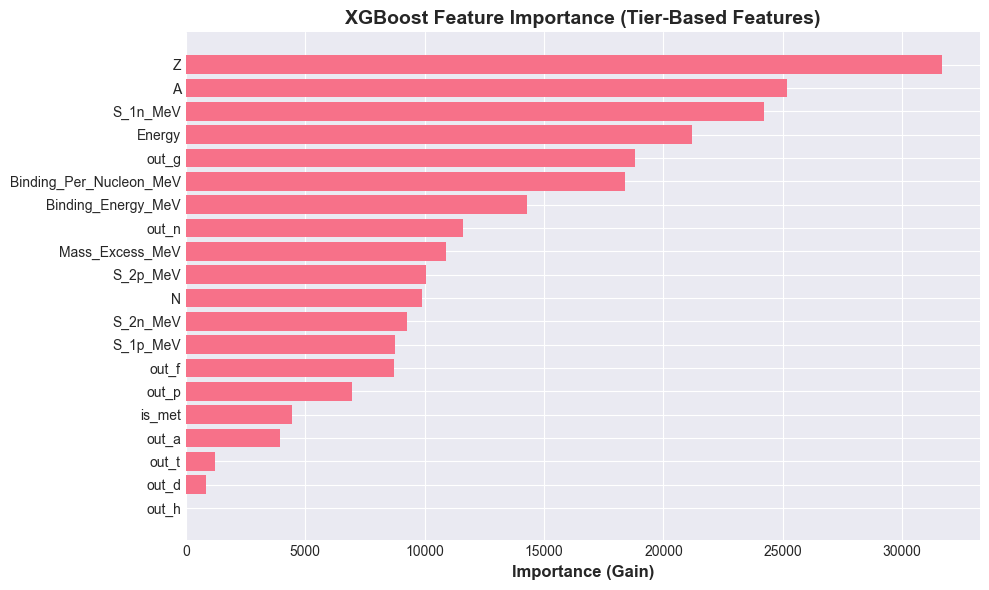


Top 5 Most Important Features:
     Feature    Importance
12         Z  31673.291016
14         A  25156.460938
15  S_1n_MeV  24204.935547
16    Energy  21177.593750
1      out_g  18813.681641


In [8]:
# Get feature importance
importance = xgb_model.get_feature_importance()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance['Feature'], importance['Importance'])
ax.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_title('XGBoost Feature Importance (Tier-Based Features)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance.head())